In [1]:
# Magic comands
%reload_ext autoreload
%autoreload 2

# Libraries
import os, sys
import numpy as np
import pandas as pd
import plotly.graph_objects as go

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

origin_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(origin_path, os.pardir))
os.chdir(parent_dir)

from app.nqueens import NQueensGeneticAlgorithm

In [2]:
def genetic_algorithm(
                    n = 8,
                    pop = 100,
                    gen = 50,
                    mut_perc = .05,
                    cross_perc = 0.75,
                    mut='swap_mutation',
                    cross='pmx',
                    select='tournament_selection',
                    ):
    
    nQueensGA = NQueensGeneticAlgorithm(population_size=pop, dimension=n)

    nQueensGA.run(
        generations=gen,
        mutation_probability=mut_perc,
        crossover_probability=cross_perc,
        mutation_operator=mut,
        crossover_operator=cross,
        selection_operator=select
    )

    return nQueensGA.report()

In [3]:
# testing function
ga = genetic_algorithm(
                                            n = 8,
                                            pop = 100,
                                            gen = 500,
                                            mut_perc = .02,
                                            cross_perc = .8,
                                            mut = "swap_mutation",
                                            cross = "single_cross",
                                            select = "tournament_selection"
                                            )
ga

{'generations': 500,
 'duration': 202,
 'best_fitness': 26,
 'best_fitness_percentage': 92.85714285714286,
 'best_representation': [1, 4, 2, 7, 1, 3, 0, 6],
 'worst_fitness': 24,
 'worst_representation': [1, 4, 2, 1, 7, 3, 0, 6],
 'mean_fitness': 25.98,
 'selection_operator': 'tournament_selection',
 'mutate_operator': 'swap_mutation',
 'crossover_operator': 'single_point_co'}

## __1. Optimization__

In [8]:
def best_operators_search(parameter: str, values: list):
    # dictionary with parameter names and default values 
    defaults = genetic_algorithm.__defaults__
    parameters = genetic_algorithm.__code__.co_varnames
    params = {param: val for param, val in zip(parameters, defaults)}
    # initializing variables
    best_fit = 0.0
    time_fit = 9e99
    fit_dict = {}
    time_dict = {}
    param_list = []

    # Perform grid search
    for i in values:
        # 100 iterations to generate statistically relevant results
        fit_list = []
        time_list = []
        for _ in range(100):
            # changing parameter according to input
            params[parameter] = i
            # Define the model with current hyperparameters
            ga = genetic_algorithm(**params)
            # gets restults
            fit = ga['best_fitness_percentage']
            time_it = ga['duration']
            # Check if current solution has better fitness than previous best 
            if fit > best_fit:
                best_fit = fit
                time_fit = time_it
                best_param = {parameter: i}
            # Check if the solution with fitness as good is faster than previous best
            if fit == best_fit and time_it < time_fit:
                time_fit = time_it
                best_param = {parameter: i}
            # Append results to get 100 iterations values
            fit_list.append(fit)
            time_list.append(time_it)
        # saving results per parameter
        param_list.append(best_param)
        fit_dict['Fit_' + i] = fit_list
        time_dict['Time_' + i] = time_list

    unique_best_params =list({tuple(d.items()): d for d in param_list}.values())

    # dataframe with results
    fit_dict.update(time_dict)
    df = pd.DataFrame(fit_dict)
        
    return unique_best_params, df

### __1.1 Mutation Module__

In [9]:
# Define the range of values for each hyperparameter
#xo = ['single_cross', 'cycle_cross', 'pmx', 'arithmetic_cross']
#select = ['tournament_selection', 'stochastic_universal_sampling']
mutation = ['swap_mutation', 'random_mutation', 'inversion_mutation']
#population = [100, 250, 500, 1000]
#generations = [100, 250, 500]
#cross_percentage = np.arange(0.8, 0.95, 0.05)
#mut_percentage = np.arange(0.01, 0.06, 0.01)

param_list, df = best_operators_search('mut', mutation)

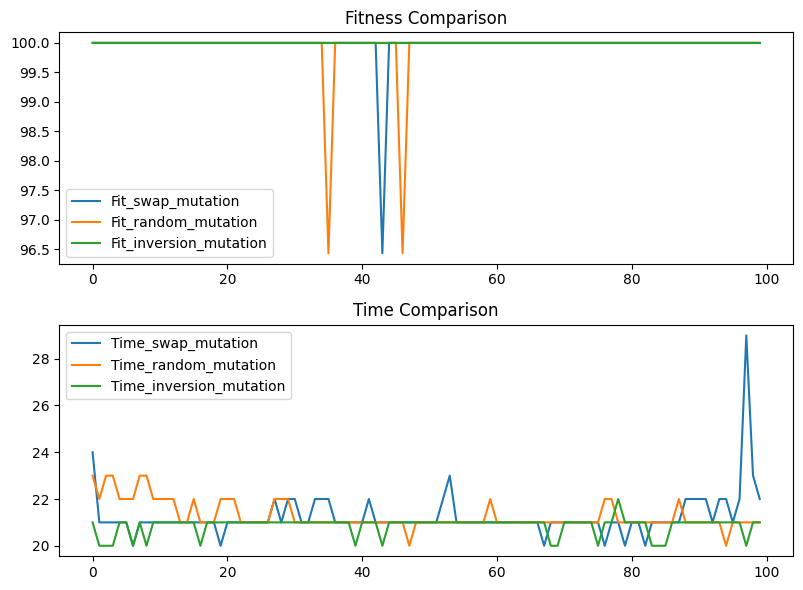

In [10]:
import matplotlib.pyplot as plt

# Filter columns starting with "Fit_"
fit_columns = [col for col in df.columns if col.startswith("Fit_")]

# Filter columns starting with "Time_"
time_columns = [col for col in df.columns if col.startswith("Time_")]

# Create a subplot with two plots
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Line plot for "Fit_" columns
axs[0].set_title("Fitness Comparison")
for col in fit_columns:
    axs[0].plot(df[col], label=col)
axs[0].legend()

# Line plot for "Time_" columns
axs[1].set_title("Time Comparison")
for col in time_columns:
    axs[1].plot(df[col], label=col)
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [1]:
# Filter columns starting with "Fit_"
fit_columns = [col for col in df.columns if col.startswith("Fit_")]

# Filter columns starting with "Time_"
time_columns = [col for col in df.columns if col.startswith("Time_")]

# Create a subplot with two line plots
fig = go.Figure()

# Add line plots for "Fit_" columns
for col in fit_columns:
    fig.add_trace(go.Scatter(x=df.index, y=df[col], name=col.replace("Fit_", "")))

fig.update_layout(title="Fitness Comparison",
                    xaxis_title="Iterations",
                    yaxis_title="Fitness")

# Add line plots for "Time_" columns
fig2 = go.Figure()

for col in time_columns:
    fig2.add_trace(go.Scatter(x=df.index, y=df[col], name=col.replace("Time_", "")))

fig2.update_layout(title="Time Comparison",
                    xaxis_title="Iterations",
                    yaxis_title="Time (ms)")

# Show the plots
fig.show()
fig2.show()

NameError: name 'df' is not defined

In [27]:
df['const'] = 'const'
df.groupby('const').mean().reset_index(drop=True).round(3)

,Fit_swap_mutation,Fit_random_mutation,Fit_inversion_mutation,Time_swap_mutation,Time_random_mutation,Time_inversion_mutation
0,99.964,99.929,100.0,21.25,21.27,20.86
